In [14]:
import os
import pandas as pd

source_dir = r"/Users/tiffany/Desktop/CS 5324/Lab 2/Images"

filepaths=[]
filelist=os.listdir(source_dir)
for f in filelist:
    fpath = os.path.normpath(os.path.join(source_dir, f))
    filepaths.append(fpath)
Fseries=pd.Series(filepaths, name='filepaths')
df=pd.concat([Fseries], axis=1)

df.info

<bound method DataFrame.info of                                               filepaths
0     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R7...
1     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/rK...
2     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/r3...
3     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R4...
4     /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R6...
...                                                 ...
1995  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/r7...
1996  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R6...
1997  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/r5...
1998  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/r7...
1999  /Users/tiffany/Desktop/CS 5324/Lab 2/Images/R7...

[2000 rows x 1 columns]>

In [15]:
# Code adapted from github Coilot to reduce the pixel size from 400x400 to 64x64

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

print(f"Processing {len(df)} chess images...")
start_time = time.time()

# Get image dimensions from first image
first_img = plt.imread(df.iloc[0]['filepaths'])
print(f"Original image size: {first_img.shape}")

# High-quality resolution with 2K images (224x224 for excellent detail)
target_size = (224, 224)  # High quality - can see individual chess pieces clearly
print(f"Downsampling to: {target_size}")

# Limit to 2000 images for better quality/memory balance
n_samples = min(2000, len(df))
n_features = target_size[0] * target_size[1]
memory_estimate_gb = (n_samples * n_features * 4) / (1024**3)

df_subset = df.iloc[:n_samples].copy()
X = np.zeros((len(df_subset), n_features), dtype=np.float32)

# Process images in batches
batch_size = 100
for batch_start in range(0, len(df_subset), batch_size):
    batch_end = min(batch_start + batch_size, len(df_subset))
    
    for i in range(batch_start, batch_end):
        img = plt.imread(df_subset.iloc[i]['filepaths'])
        
        # Convert to grayscale if color image
        if len(img.shape) == 3:
            img = np.mean(img, axis=2)
        
        # Resize image using PIL
        img_pil = Image.fromarray((img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8))
        img_resized = img_pil.resize(target_size, Image.Resampling.LANCZOS)
        img_array = np.array(img_resized, dtype=np.float32) / 255.0
        
        X[i] = img_array.flatten()

h, w = target_size  # Set dimensions for later use
end_time = time.time()
print(f"\nProcessing completed in {end_time - start_time:.2f} seconds")
print(f"Dataset shape: {X.shape}")

Processing 2000 chess images...
Original image size: (400, 400, 3)
Downsampling to: (224, 224)

Processing completed in 6.68 seconds
Dataset shape: (2000, 50176)


/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_36226/3077801563.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx_to_reconstruct = int(np.random.rand(1)*len(X))
/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_36226/3077801563.py:10: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(img)
/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_36226/3077801563.py:16: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(gradient_mag)


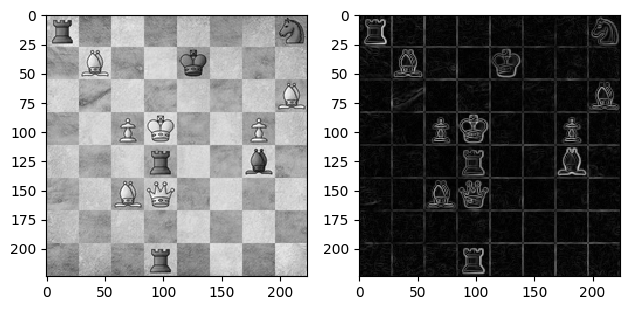

In [17]:
# adapted from 3. Data Visualization ipynb Eric Larson lab

from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v

plt.subplot(1,2,1)
idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((h,w))
imshow(img)
plt.grid(False)


plt.subplot(1,2,2)
gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)
plt.grid(False)
plt.show()

/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_36226/564585466.py:11: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(img_desc)


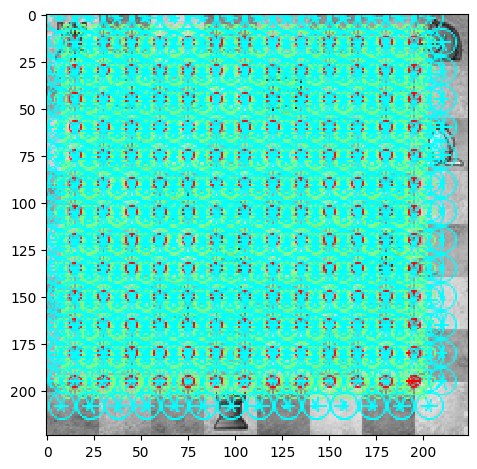

In [18]:
from skimage.feature import daisy

features, img_desc = daisy(img, 
                           step=15, 
                           radius=15, 
                           rings=2, 
                           histograms=6, 
                           orientations=6, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)
plt.show()

In [19]:
# used from 3. Data Visualization ipynb Eric Larson lab to get the shape of the feature array
features = daisy(img, step=10, radius=20, rings=2, histograms=8, orientations=4, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(19, 19, 68)
24548


In [20]:
# used from 3. Data Visualization ipynb Eric Larson lab to apply the daisy function to all images
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=10, radius=20, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(h,w))
test_feature.shape

CPU times: user 53.3 ms, sys: 3.41 ms, total: 56.7 ms
Wall time: 18.6 ms


(24548,)

In [21]:
0.018 * len(X) # approximate how long it may run

36.0

In [22]:
# used from 3. Data Visualization Eric Larson
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

CPU times: user 30 s, sys: 3.43 s, total: 33.4 s
Wall time: 33.5 s
(2000, 24548)


In [23]:
# used from 3. Data Visualization ipynb Eric Larson lab to find the pairwise distance between all the different image features

from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 21.3 s, sys: 1.96 s, total: 23.2 s
Wall time: 2.55 s


/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_36226/3397270633.py:10: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X[idx1].reshape((h,w)))
/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_36226/3397270633.py:15: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X[idx2].reshape((h,w)))


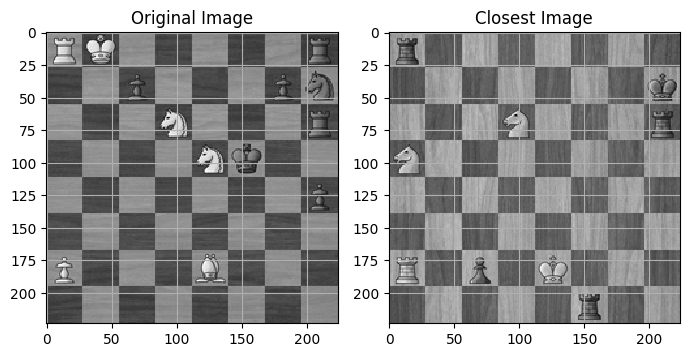

In [24]:
# used from 3. Data Visualization ipynb Eric Larson lab to find the closest image to a given image

import copy
# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()